## 1. Imports

In [68]:
import torch
# Download an example image from the pytorch website
import urllib
from PIL import Image as Image 
from torchvision import transforms
from IPython.display import Image as show_img
import numpy as np
import pandas as pd
from lime import lime_image
from skimage.segmentation import mark_boundaries, find_boundaries
import matplotlib.pyplot as plt
import cv2

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()
explanations = []

## 2. Functions

In [69]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

def predict(pill_transf, preprocess_transform, image):
    input_tensor = preprocess_transform(pill_transf(image))
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    predicted = torch.nn.functional.softmax(output[0], dim=0).argmax()
    scores = torch.nn.functional.softmax(output[0], dim=0)
    y_hat = pd.read_csv('labels.csv',index_col = 'id').loc[int(predicted)+1].label
    return y_hat, predicted, scores

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    #batch =preprocess_transform(images).unsqueeze(0)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def output_image(img):
    img_gray = rgb2gray(img)    
    plt.imshow(img_gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()
    return img_gray

def show_input_image(filename):
    input_image = Image.open(filename)
    print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image)[0]))
    img_big = show_img(filename=filename,retina=True)
    return img_big, input_image

def lime_explanation(input_image):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(input_image)), 
                                             batch_predict, # classification function
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry1)
    return explanation

## 3. Load model

In [70]:
model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in C:\Users\Asus/.cache\torch\hub\pytorch_vision_v0.4.2


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

## 4. Examples of the 5 best classifications

Prediction of MobileNet: harp


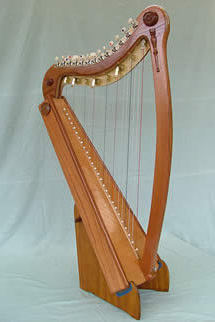

In [71]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0001.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

## 4.1. True label - harp; Predicted label - harp 

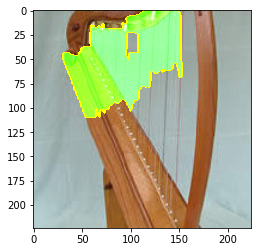

In [72]:
explanations.append(lime_explanation(input_image))

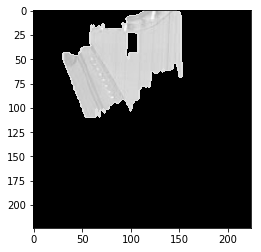

In [73]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 4.2. True label - harp ; Predicted label - harp

Prediction of MobileNet: harp


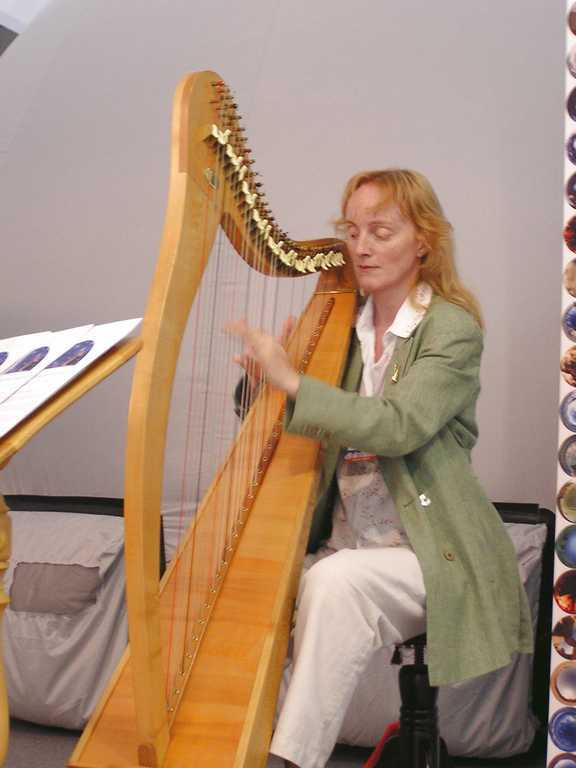

In [74]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0007.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

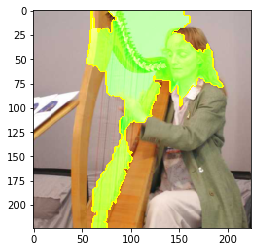

In [75]:
explanations.append(lime_explanation(input_image))

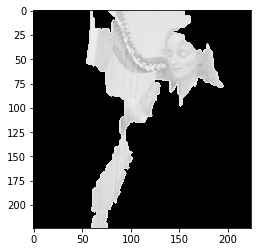

In [76]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 4.3. True label - harp ; Predicted label - harp

Prediction of MobileNet: harp


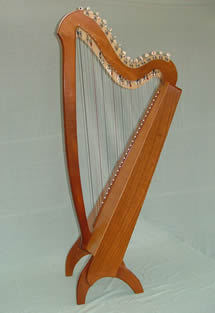

In [77]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0015.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

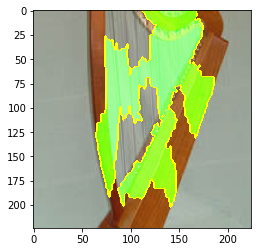

In [78]:
explanations.append(lime_explanation(input_image))

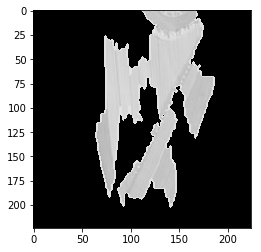

In [79]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 4.4. True label - harp ; Predicted label - harp

Prediction of MobileNet: harp


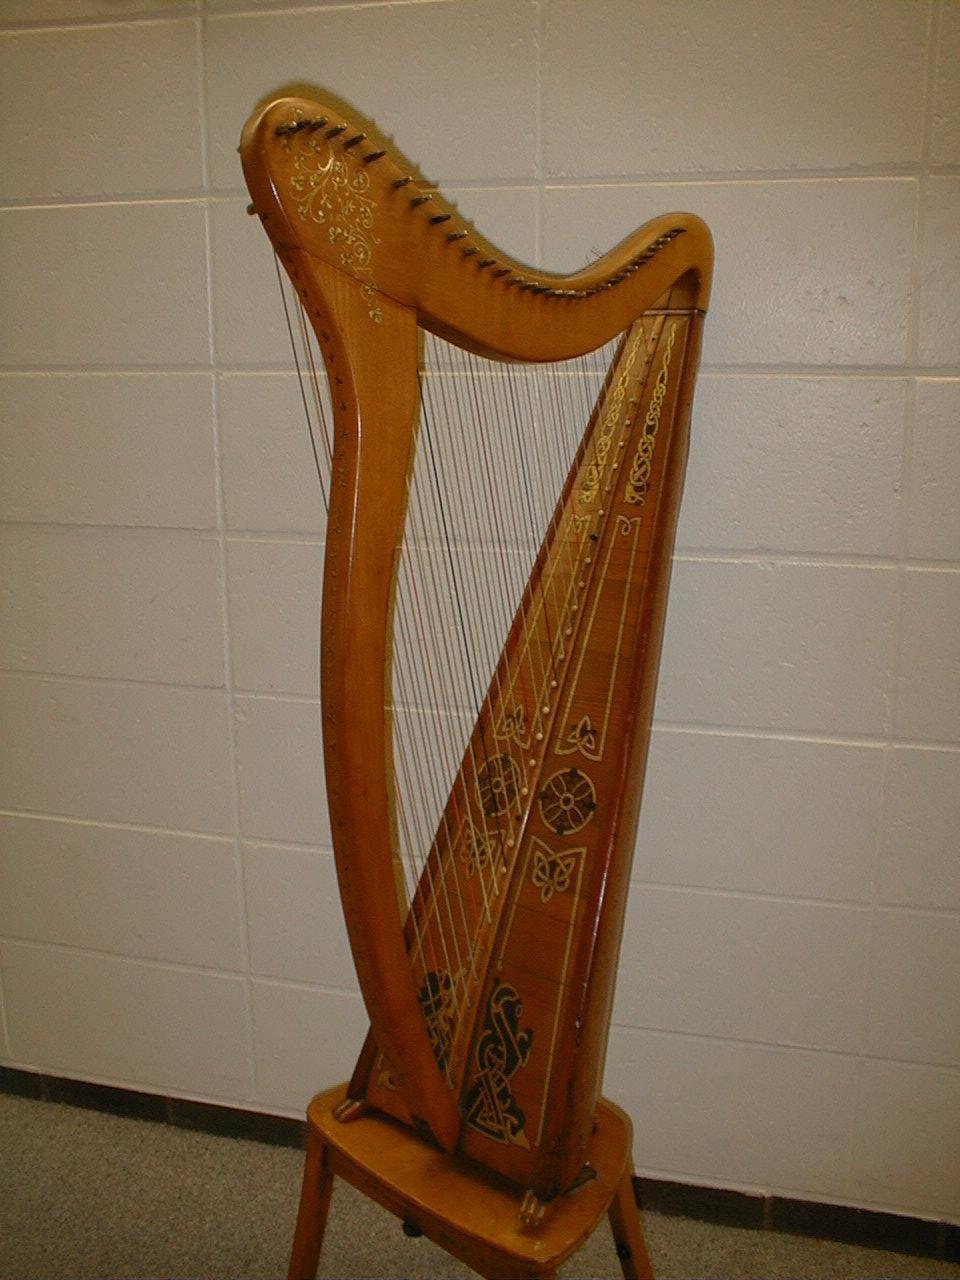

In [80]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0026.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

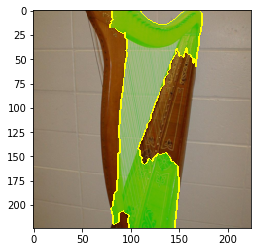

In [81]:
explanations.append(lime_explanation(input_image))

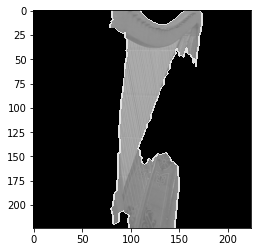

In [82]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 4.5. True label - harp ; Predicted label - harp

Prediction of MobileNet: harp


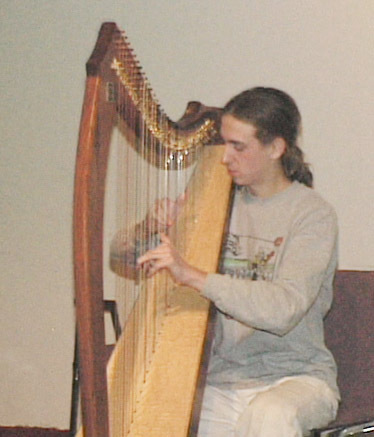

In [83]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0031.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

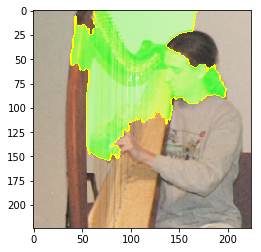

In [84]:
explanations.append(lime_explanation(input_image))

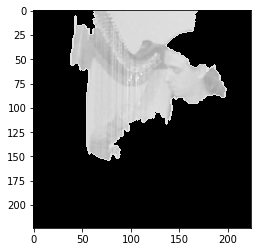

In [85]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 5. Examples of the 5 worst classifications 

## 5.1. True label - canoe ; Predicted label - Thatch, thatches roof

Prediction of MobileNet: thatch, thatched roof


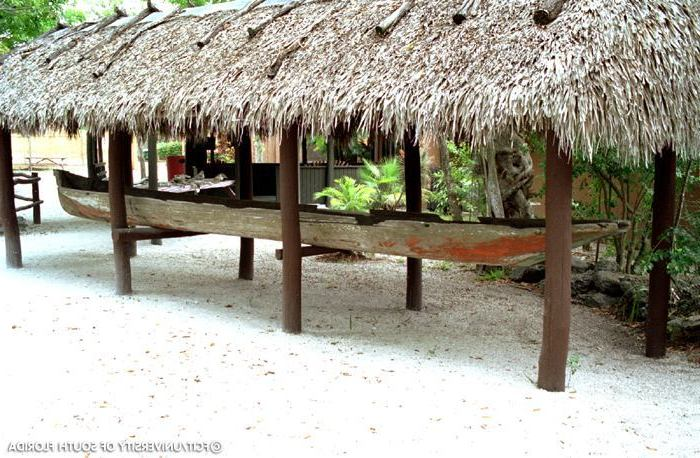

In [86]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/030.canoe/030_0086.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

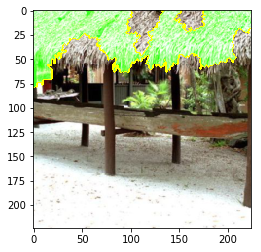

In [87]:
explanations.append(lime_explanation(input_image))

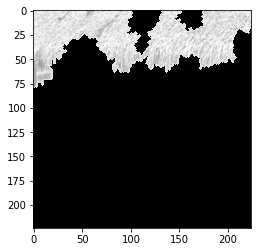

In [88]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 5.2. True label - rifle ; Predicted label - hartbeest

Prediction of MobileNet: hartebeest


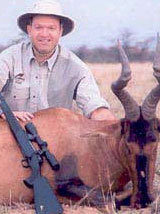

In [89]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/173.rifle/173_0030.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

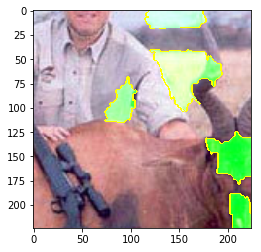

In [90]:
explanations.append(lime_explanation(input_image))

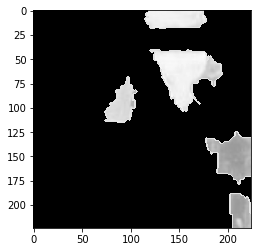

In [91]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 5.3. True label - hummingbird ; Predicted label - little blue heron, egretta caerulea

Prediction of MobileNet: little blue heron, Egretta caerulea


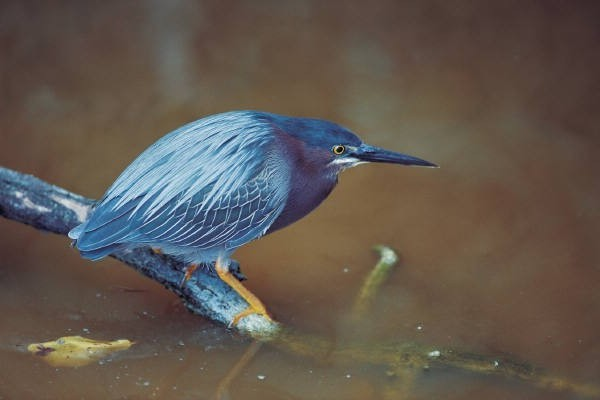

In [92]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/113.hummingbird/113_0080.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

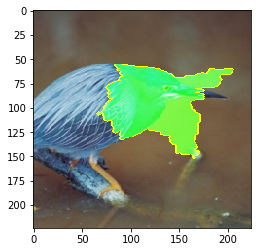

In [93]:
explanations.append(lime_explanation(input_image))

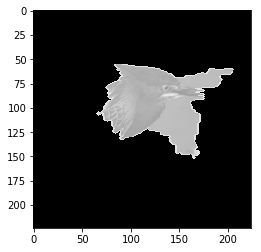

In [94]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 5.4. True label - Mushroom ; Predicted label - coho, choe, coho salmon, blue jack, silver salmon, onchorhynchus kisutch

Prediction of MobileNet: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch


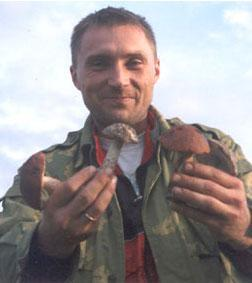

In [95]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/147.mushroom/147_0064.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

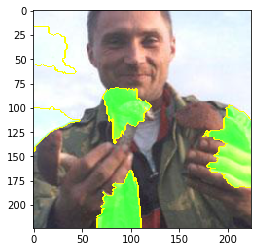

In [96]:
explanations.append(lime_explanation(input_image))

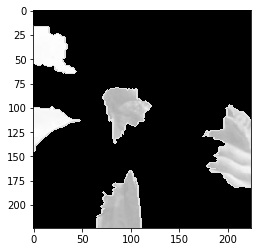

In [97]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 5.5. True label - soccer ball ; Predicted label - ocarina, sweet potato

Prediction of MobileNet: ocarina, sweet potato


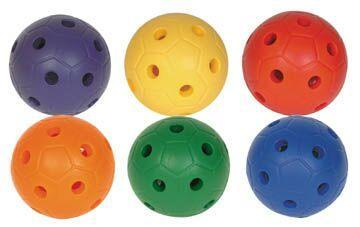

In [98]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/193.soccer-ball/193_0094.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

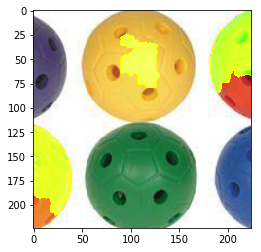

In [99]:
explanations.append(lime_explanation(input_image))

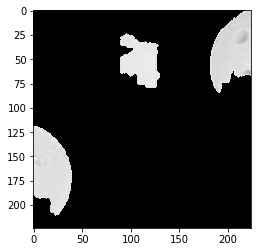

In [100]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

# 6. Other samples

## 6.1. True label - cannon ; Predicted label - cannon

Prediction of MobileNet: cannon


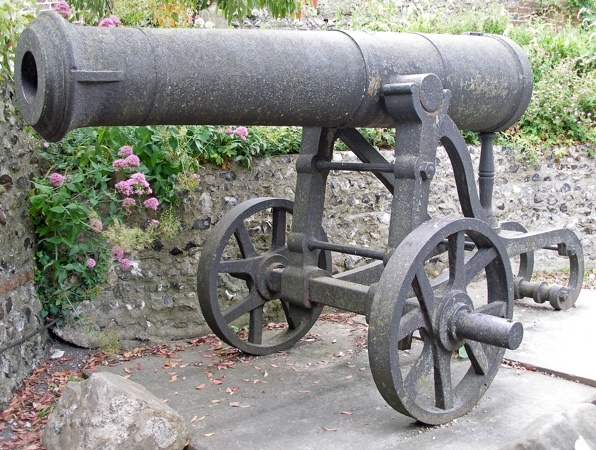

In [101]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/029.cannon/029_0033.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

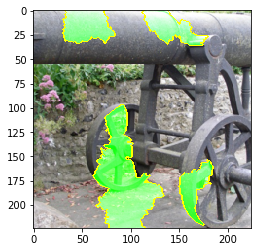

In [102]:
explanations.append(lime_explanation(input_image))

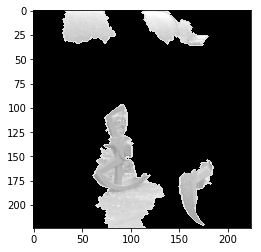

In [103]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.2. True label - centipede ; Predicted label - centipede

Prediction of MobileNet: centipede


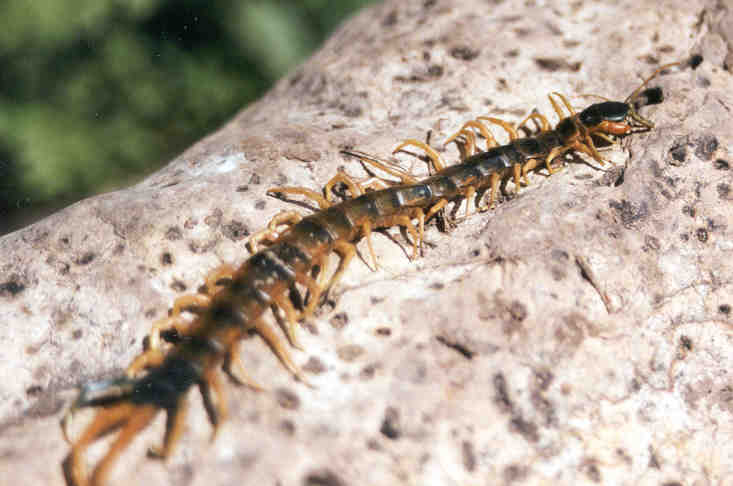

In [104]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/034.centipede/034_0036.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

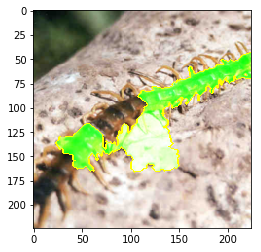

In [105]:
explanations.append(lime_explanation(input_image))

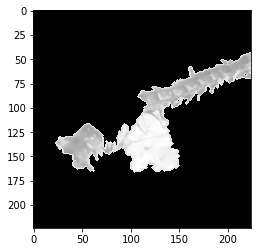

In [106]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.3. True label - golf ball ; Predicted label - golf ball

Prediction of MobileNet: golf ball


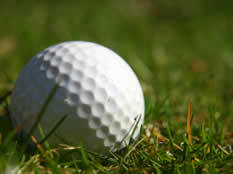

In [107]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/088.golf-ball/088_0092.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

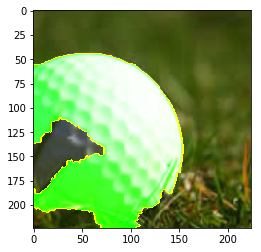

In [108]:
explanations.append(lime_explanation(input_image))

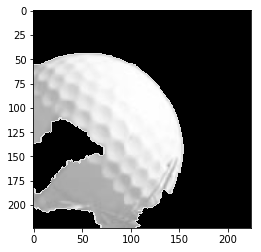

In [109]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.4. True label - football helmet ; Predicted label - football helmet

Prediction of MobileNet: football helmet


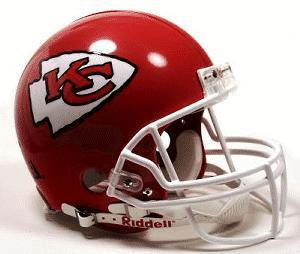

In [110]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/076.football-helmet/076_0045.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

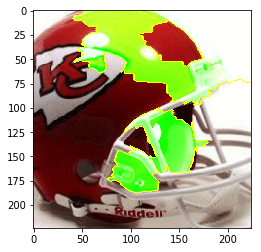

In [111]:
explanations.append(lime_explanation(input_image))

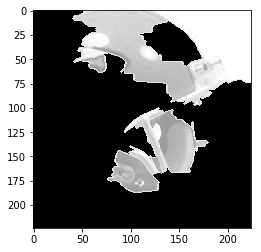

In [112]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.5. True label - cannon ; Predicted label - cannon

Prediction of MobileNet: cannon


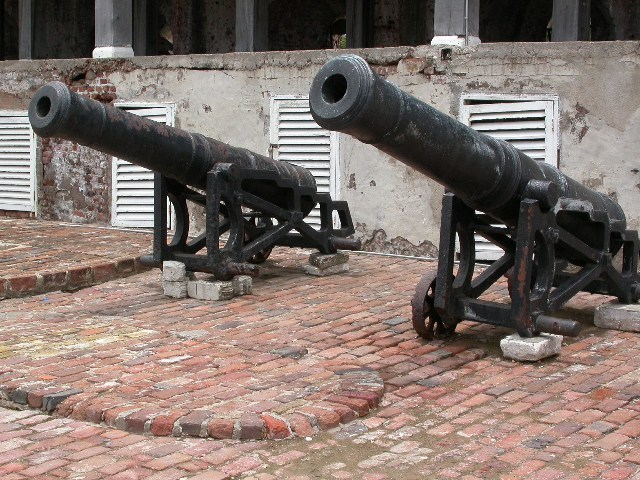

In [113]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/029.cannon/029_0084.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

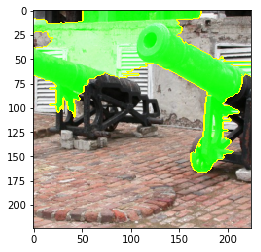

In [114]:
explanations.append(lime_explanation(input_image))

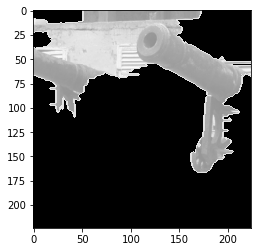

In [115]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.6. True label - cannon ; Predicted label - cannon

Prediction of MobileNet: photocopier


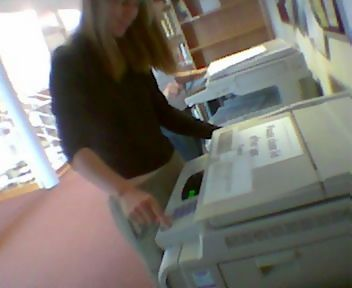

In [116]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/161.photocopier/161_0069.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

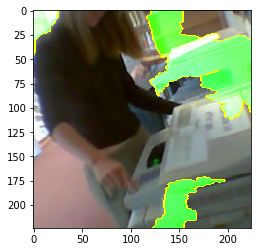

In [117]:
explanations.append(lime_explanation(input_image))

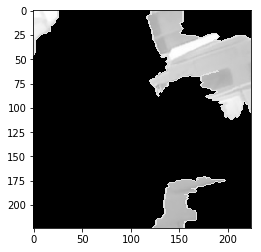

In [118]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.7. True label - cannon ; Predicted label - cannon

Prediction of MobileNet: conch


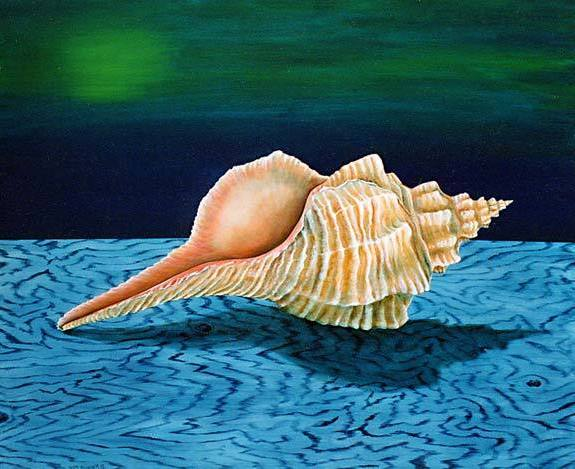

In [119]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/048.conch/048_0012.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

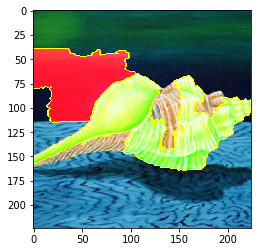

In [120]:
explanations.append(lime_explanation(input_image))

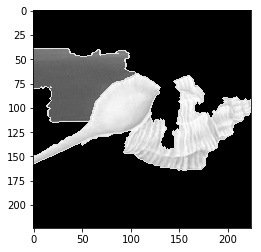

In [121]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.8. True label - cannon ; Predicted label - cannon

Prediction of MobileNet: goose


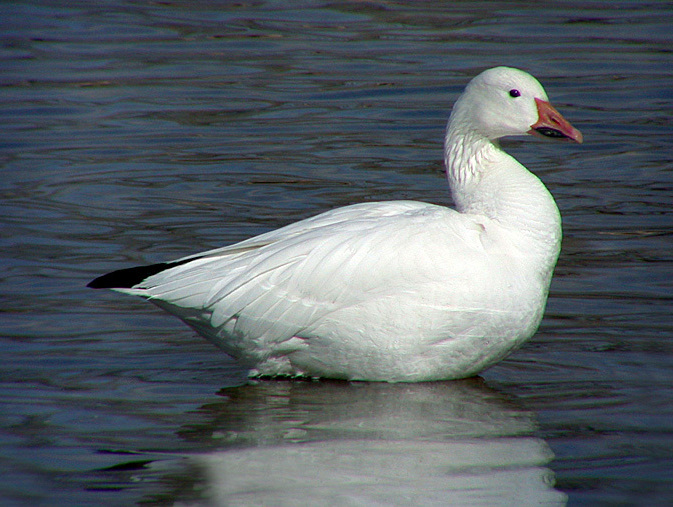

In [122]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/089.goose/089_0046.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

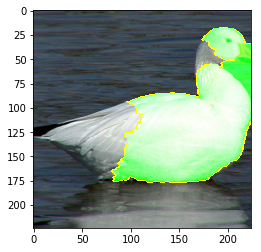

In [123]:
explanations.append(lime_explanation(input_image))

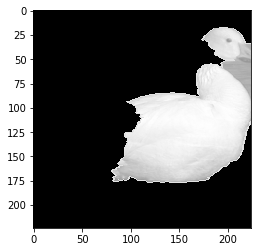

In [124]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.9. True label - cannon ; Predicted label - cannon

Prediction of MobileNet: zebra


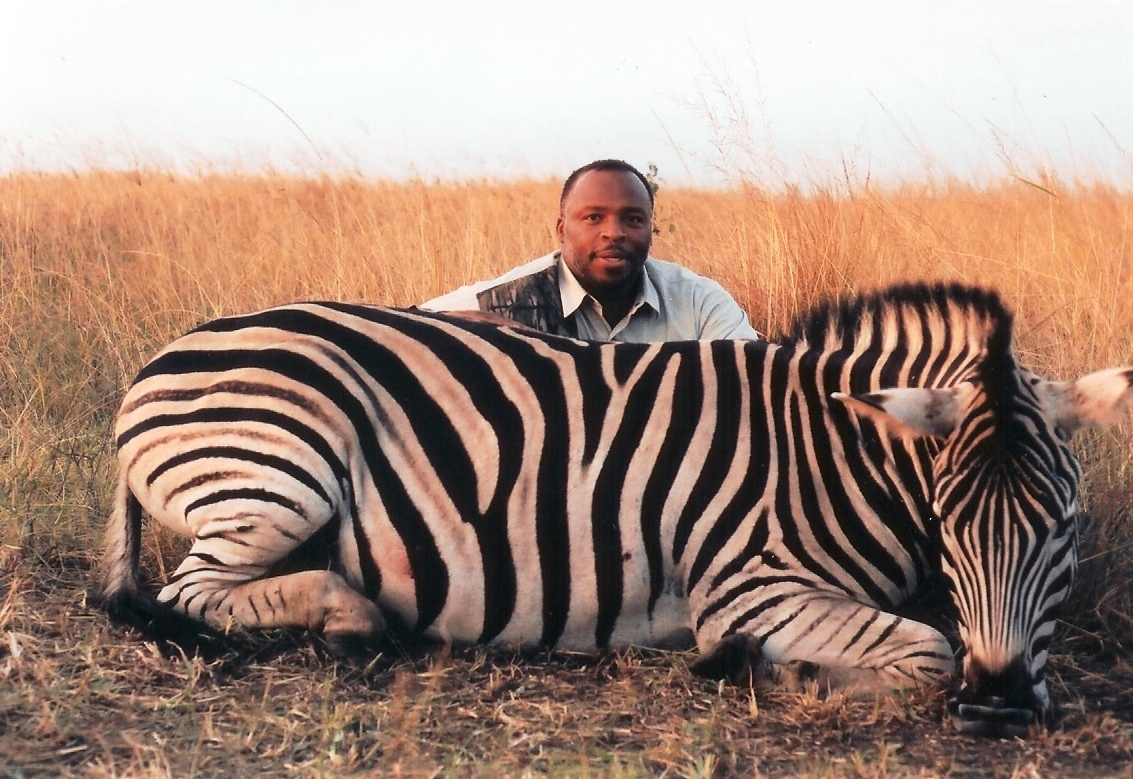

In [125]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/250.zebra/250_0040.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

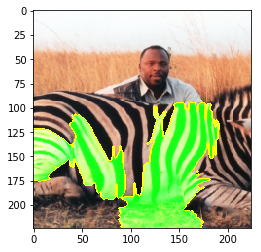

In [126]:
explanations.append(lime_explanation(input_image))

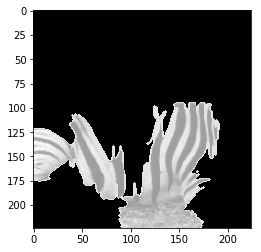

In [127]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

## 6.10. True label - cannon ; Predicted label - cannon

Prediction of MobileNet: electric guitar


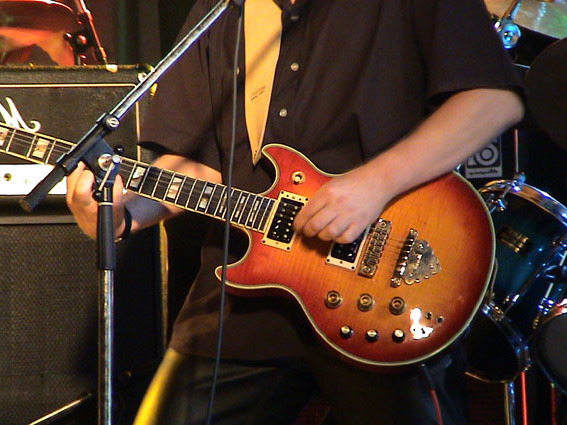

In [128]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/063.electric-guitar-101/063_0018.jpg"
img_plot, input_image = show_input_image(filename)
show_img(img_plot.data,width=img_plot.width/2)

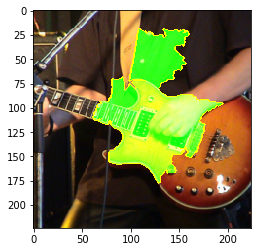

In [129]:
explanations.append(lime_explanation(input_image))

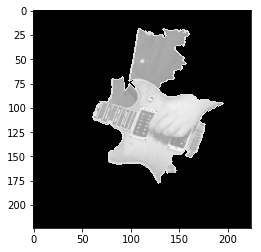

In [130]:
temp, mask = explanations[-1].get_image_and_mask(explanations[-1].top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)